In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math
import glob
from google.colab.patches import cv2_imshow
import pandas as pd
from scipy.optimize import least_squares
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def cornersHomo(all_images,world_points):
    all_Homography_matrices=[]
    all_corners = []
    CHECKERBOARD = (9,6)
    for image in all_images:
      grayscale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      _,corners=cv2.findChessboardCorners(grayscale, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
      all_corners.append(corners)
      H4pt = []
      for i in range(54):
          cv2.circle(image, (int(corners[i][0][0]), int(corners[i][0][1])), 1, [0,200,0], -1) 
          # cv2_imshow(image)
          # if i == 0 or i == 8 or i == 53 or i == 45:
          H4pt.append(corners[i][0])

      H4pt = np.array(H4pt)
      # print(H4pt.shape)
      # H4pt[[2,3]] = H4pt[[3,2]]
      # print(H4pt)
      #  if i == 0 or i == 8 or i == 45 or i == 53:
      #     cv2.circle(grayscale, (corner[j,i,0].astype(int), corner[j,i,1].astype(int)), 20, [255,0,255])
      # # cv2_imshow(grayscale)
      # dest = np.array([[corner[j][0][0],corner[j][0][1]],[corner[j][8][0],corner[j][8][1]],[corner[j][53][0],corner[j][53][1]],[corner[j][45][0],corner[j][45][1]]],dtype='float32') 
      # for k in range(corner.shape[1]):
      #   cv2.circle(grayscale, (corner[j,k,0].astype(int), corner[j,k,1].astype(int)), 2, [0,0,255], 2)
      # cv2_imshow(grayscale)
      # print(f"c = {corner[j,:,:]}, wp = {worldAllPoints}")
      H_Img_World,_=cv2.findHomography(world_points,H4pt)
      all_Homography_matrices.append(H_Img_World)
      # cv2_imshow(image)
    all_Homography_matrices=np.array(all_Homography_matrices)
    # print(all_Homography_matrices.shape)
    return all_Homography_matrices,all_corners


def v(H,i,j):
  return np.reshape(np.array([H[0,i]*H[0,j], H[0,i]*H[1,j]+H[1,i]*H[0,j], H[1,i]*H[1,j], H[2,i]*H[0,j]+H[0,i]*H[2,j], H[2, i]*H[1,j]+H[1,i]*H[2,j], H[2,i]*H[2,j]]),(6,1))

def intrinsics(all_Homographies):
    V1 = []
    for i,HM in enumerate(all_Homographies):
      # print(v(HM,0,1).shape)
      V1.append(v(HM,0,1))
      V1.append(v(HM,0,0) - v(HM,1,1))
    V1 = np.array(V1)
    V1 = np.squeeze(V1, axis = 2)
    u,s,vt = np.linalg.svd(V1)
    # print(f"U = {u.shape} and s = {s.shape}")
    # print(f"vtrans = {vT.shape}")
    index_min = np.argmin(s)
    b = vt[index_min]
    B11 = b[0]
    B12 = b[1]
    B22 = b[2]
    B13 = b[3]
    B23 = b[4] 
    B33 = b[5]
    # print(vT)
    v0 = (B12*B13 - B11*B23)/(B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23))/B11
    alpha = np.sqrt(lam/B11)
    beta = np.sqrt(lam*B11 /(B11*B22 - B12**2))
    gamma = -1*B12*(alpha**2)*beta/lam
    u0 = gamma*v0/beta -B13*(alpha**2)/lam
    K = np.array([[alpha, gamma, u0],[0, beta, v0],[0, 0, 1]])
    print(f"alpha = {alpha} and lambda = {lam} and vo = {v0} and  beta = {beta} and uo = {u0} and gamma = {gamma} and \n A_init = {K}")
    return K

def extrinsics(A, all_Homographies):
    A_inv = np.linalg.inv(A)
    extrinsic_All = []
    for H in all_Homographies:
        H1 = H[:,0]
        H2 = H[:,1]
        H3 = H[:,2]
        # print(H1,H2,H3)
        norm1 = np.linalg.norm(np.dot(A_inv,H1))
        norm2 = np.linalg.norm(np.dot(A_inv,H2))
        lam = 1/norm1
        # print("norm2", norm2)
        # if round(norm1,2) == round(norm2,2):
          # print("norms are equal")
        R1 = lam*np.dot(A_inv,H1)
        R2 = lam*np.dot(A_inv,H2)
        R3 = np.cross(R1,R2)
        T = lam*np.dot(A_inv,H3)
        R = np.array([R1,R2,R3]).T
        u,s,v = np.linalg.svd(R)
        R_final = np.matmul(u,v)
        ext = np.hstack((R_final,T.reshape(3,1)))
        extrinsic_All.append(ext)
        # print(ext)
    extrinsic_All = np.array(extrinsic_All)
    # print(extrinsic_All, extrinsic_All.shape)
    return extrinsic_All
        
def reprojection(A, all_homographies, all_extrensic_matrics, image_points, k1, k2):
    error = []
    x, y = np.meshgrid(range(9),range(6))
    all_world_points = np.hstack((x.reshape(54, 1), y.reshape(54, 1))).astype(np.float32)
    all_world_points = all_world_points*21.5
    projected_points = []
    u0 = A[0,2]
    v0 = A[1,2]
    for k, homography in enumerate(all_homographies):
        image_projected_points=[]
        er = 0
        ext = all_extrensic_matrics[k]
        # mat=np.matmul(A,ext)
        for cp, wp in zip(image_points[k], all_world_points):
            wp_temp=np.array([[wp[0]],[wp[1]],[0],[1]])
            temp = np.matmul(ext,wp_temp)
            temp = temp/temp[2]
            x, y = temp[0],temp[1]
            UV = np.matmul(A,temp)
            UV = UV/UV[2]
            u, v = UV[0],UV[1]
            t = x**2 + y**2
            u_cap = u + (u - u0)*(k1*t + k2*(t**2))
            v_cap = v + (v - v0)*(k1*t + k2*(t**2))
            image_projected_points.append([u_cap,v_cap])
            # print(cp[0][0])
            er = er + np.sqrt((cp[0][0] - u_cap)**2 + (cp[0][1] - v_cap)**2)
        error.append(er/len(all_world_points))
        # print(len(all_world_points))
        # error1 = np.mean(np.array(error))
        projected_points.append(image_projected_points)
    error=np.array(error)
    return error, projected_points, all_world_points

def optimizationFunction(InitCondition, A, all_Homographies, all_extrensic_matrices, all_corner_points, all_world_points):
    A = np.zeros((3,3))
    A[0, 0], A[0, 1], A[0, 2], A[1, 1], A[1, 2], k1, k2 = InitCondition
    A[2,2] = 1
    u0, v0 = InitCondition[2],InitCondition[4]
    projection_error = []
    for j, ext in enumerate(all_extrensic_matrices):
        for cp, wp in zip(all_corner_points[j], all_world_points):
            wp_temp = np.array([[wp[0]],[wp[1]],[0],[1]])
            temp = np.matmul(ext, wp_temp)
            temp = temp/temp[2]
            x, y = temp[0],temp[1]
            UV = np.matmul(A,temp)
            UV = UV/UV[2]
            u, v = UV[0],UV[1]
            t = x**2 + y**2
            u_cap = u + (u - u0)*(k1*t + k2*(t**2))
            v_cap = v + (v - v0)*(k1*t + k2*(t**2))
            projection_error.append(cp[0][0] - u_cap)
            projection_error.append(cp[0][1] - v_cap)
    projection_error = np.array(projection_error).flatten()
    # print(projection_error.shape)
    # projection_error = np.mean(np.array(projection_error))
    return projection_error

def reprojectAllImages(img_list,projected_points, all_corner_points):
    for i in range(len(img_list)):
        image = img_list[i]
        for projected_point, pt in zip(projected_points[i], all_corner_points[i]):
            x,y = int(pt[0][0]), int(pt[0][1])
            x_rp,y_rp = int(projected_point[0]), int(projected_point[1])
            cv2.circle(image,(x, y),3,(0,255,0),3)
            cv2.circle(image,(x_rp, y_rp),3,(0,0,255),3)
        if i ==1:
          cv2_imshow(image)
        # break


alpha = 2052.788166884138 and lambda = -0.6331722760245666 and vo = 1352.61456117404 and  beta = 2036.6341494517958 and uo = 763.0610889577671 and gamma = -0.36952971148561514 and 
 A_init = [[ 2.05278817e+03 -3.69529711e-01  7.63061089e+02]
 [ 0.00000000e+00  2.03663415e+03  1.35261456e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Initial Error is: 1.9675292755920457
The optimized A is : 
 [[ 2.04692615e+03 -8.34290963e-01  7.63584819e+02]
 [ 0.00000000e+00  2.03138417e+03  1.35192643e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
The optimized k1 and k2 are: 0.09543895629032123 and -0.5651459676558697
Error After optimization is: 1.843343285593818


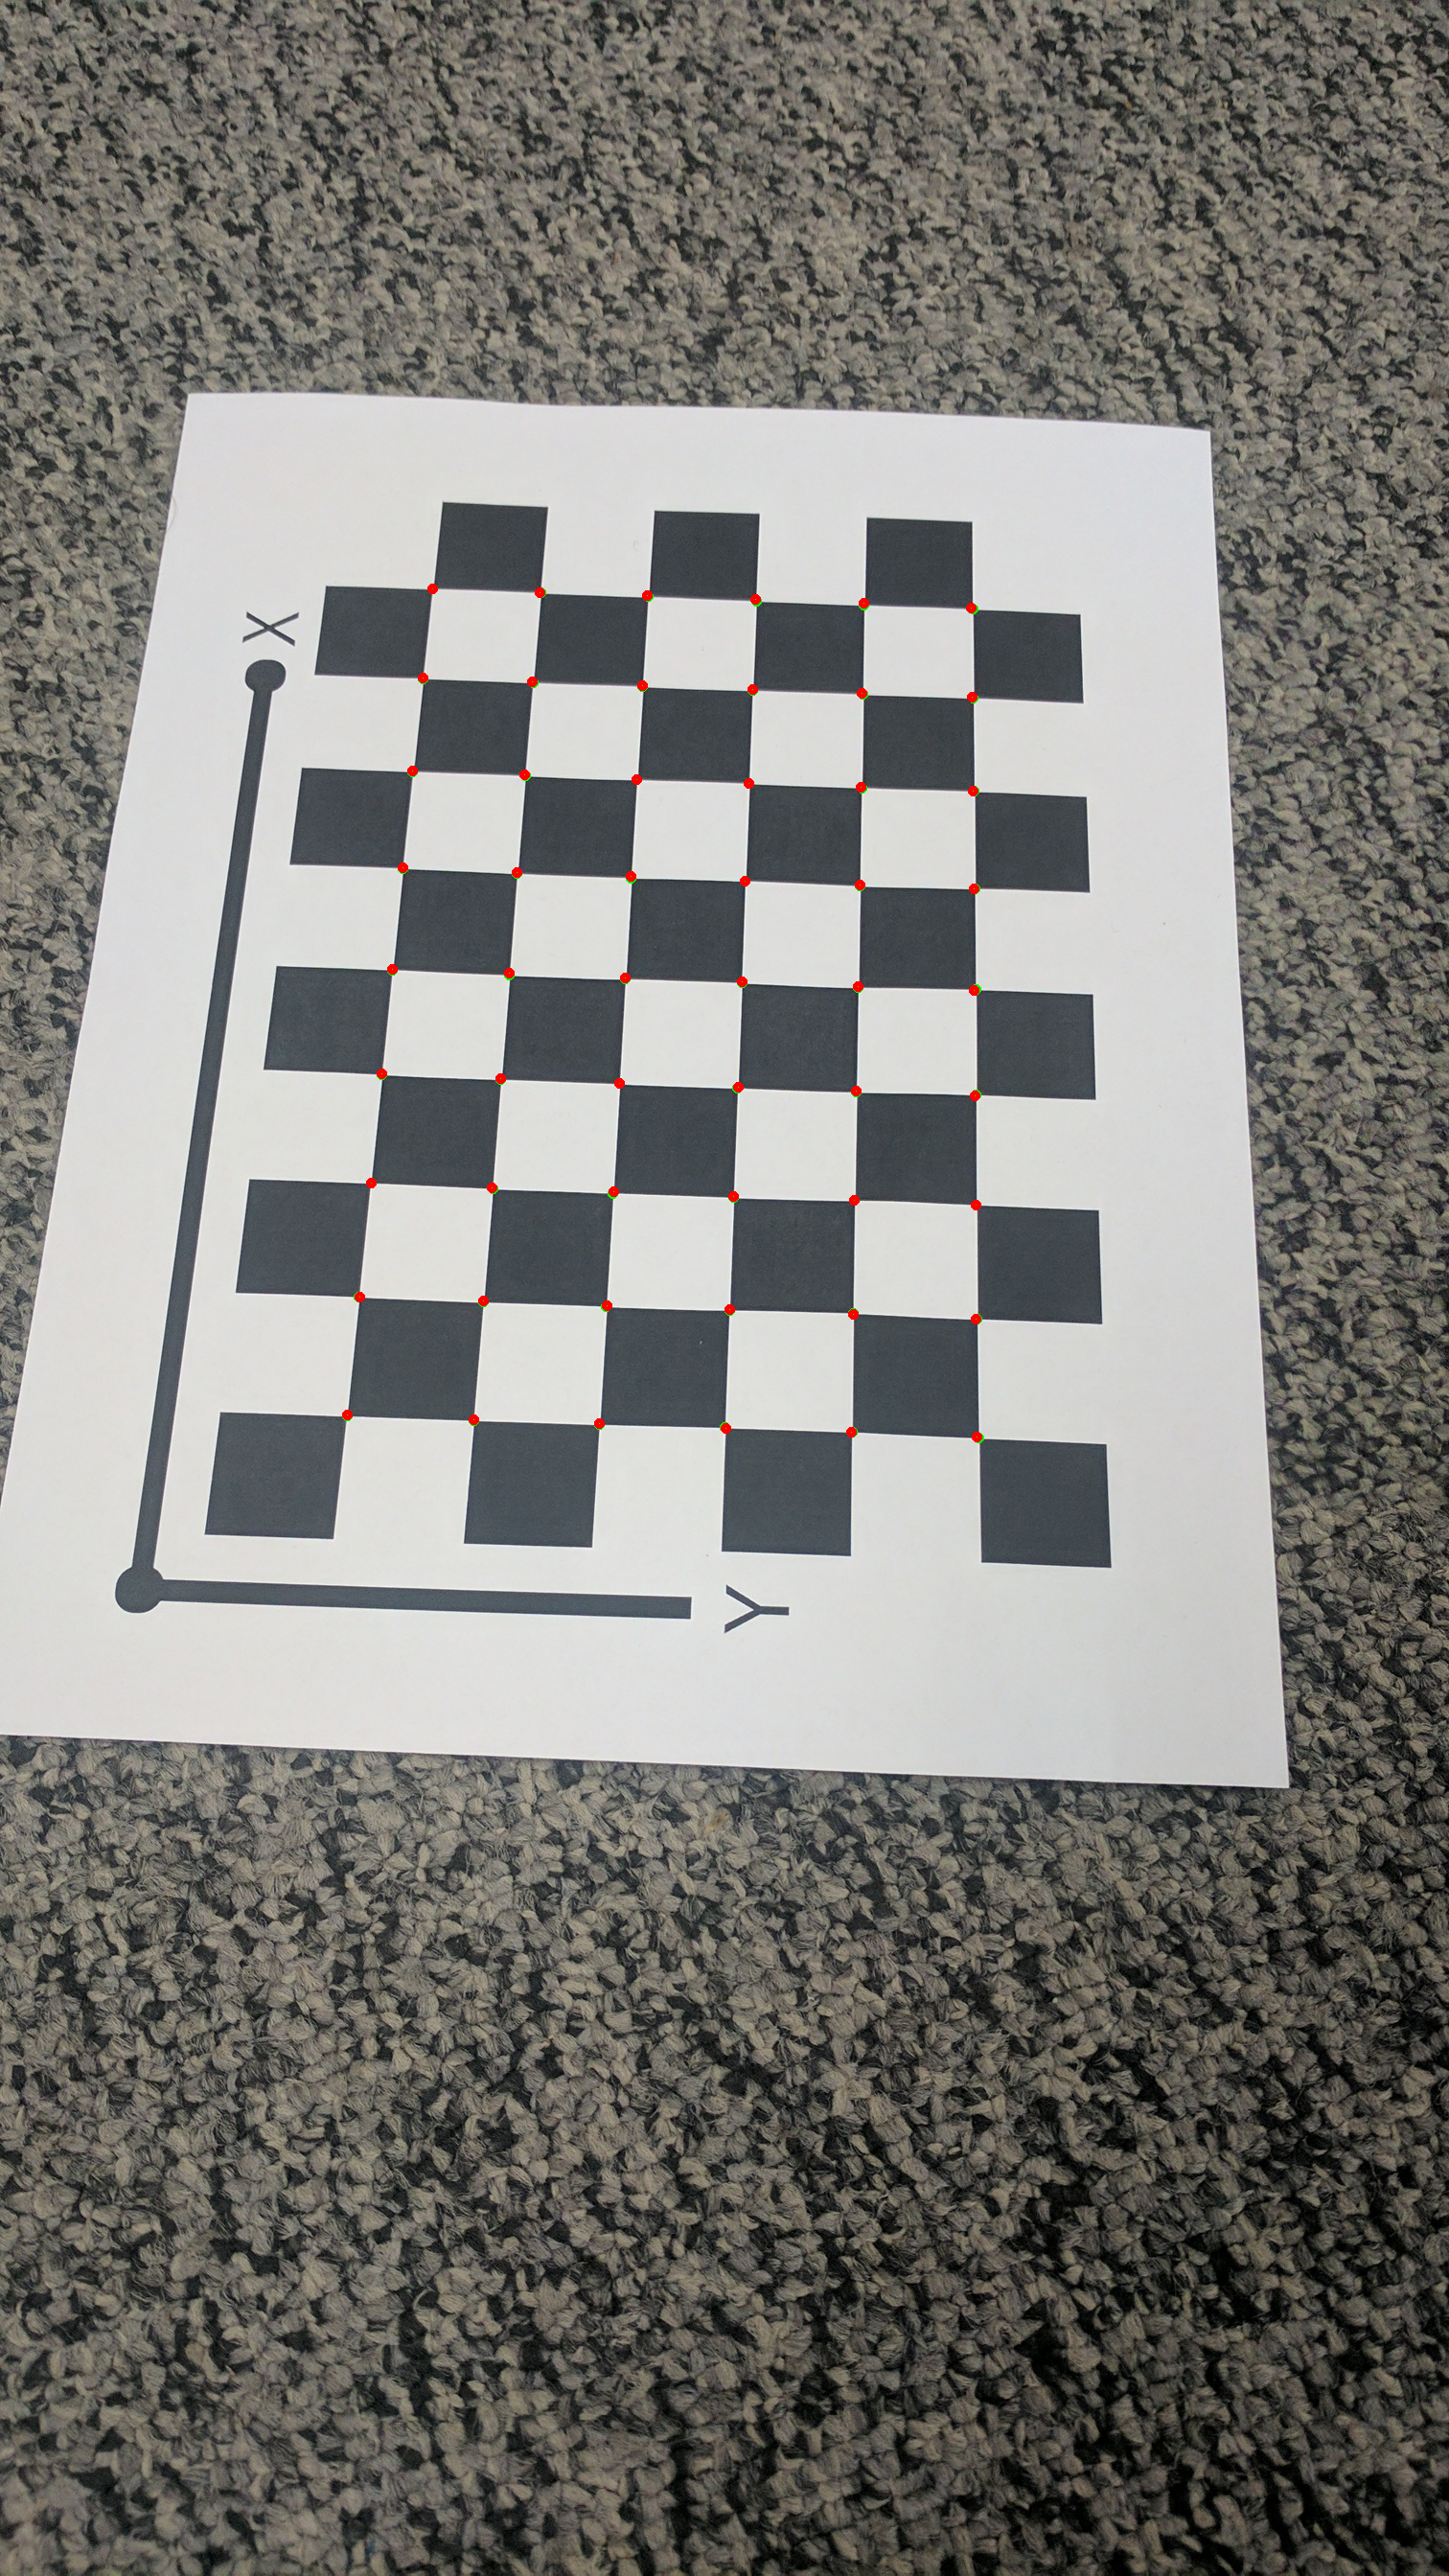

In [5]:
ref = cv2.imread("/content/drive/MyDrive/Colab Notebooks/checkerboardPattern.pdf")
lhs=glob.glob('/content/gdrive/MyDrive/Colab Notebooks/Calibration_Imgs/*.jpg')
lhs.sort()

lhs=[cv2.imread(file) for file in lhs]

# world_ref = np.array([[21.5, 21.5],
#                       [21.5*9,21.5],
#                       [21.5*9, 21.5*6],
#                       [21.5,21.5*6]], dtype='float32')  
x, y = np.meshgrid(range(9),range(6))
all_world_points = np.hstack((x.reshape(54, 1), y.reshape(54, 1))).astype(np.float32)
all_world_points = all_world_points*21.5

all_Homographies,all_corner_points = cornersHomo(lhs, all_world_points)
A = intrinsics(all_Homographies)
# print(f'The initial K is : \n {A}')
all_extrensic_matrices = extrinsics(A, all_Homographies)
error, proj_pts1, all_world_points = reprojection(A, all_Homographies, all_extrensic_matrices, all_corner_points, 0, 0)
print(f'Initial Error is: {np.mean(error)}')
# reprojectAllImages(lhs, proj_pts1, all_corner_points)
InitCondition = [A[0, 0], A[0, 1], A[0, 2], A[1, 1], A[1, 2], 0, 0]
final_parameters = least_squares(fun = optimizationFunction, x0 = InitCondition, method = "lm", args = [A, all_Homographies, all_extrensic_matrices, all_corner_points, all_world_points])
# print(final_parameters)
K_optimized = np.zeros((3,3))
K_optimized[0, 0], K_optimized[0, 1], K_optimized[0, 2], K_optimized[1, 1], K_optimized[1, 2], K_optimized[2,2] = final_parameters.x[0], final_parameters.x[1], final_parameters.x[2], final_parameters.x[3], final_parameters.x[4], 1
k1_optimized = final_parameters.x[5]
k2_optimized = final_parameters.x[6]
print(f'The optimized A is : \n {K_optimized}')
print(f'The optimized k1 and k2 are: {k1_optimized} and {k2_optimized}')
error, projected_points, _= reprojection(K_optimized, all_Homographies, all_extrensic_matrices, all_corner_points, k1_optimized, k2_optimized)
print(f'Error After optimization is: {np.mean(error)}')
reprojectAllImages(lhs,projected_points,all_corner_points)
